#Deep Reinforcement Learning for Control

## Lab Session

### 4th International Summer School on Artificial Intelligience AI-DLDA 2021





Notebook written by Matteo Dunnhofer `matteo.dunnhofer@uniud.it`

Machine Learning and Perception Lab

University of Udine

In this notebook we will see how to model and solve a toy control problem with **reinforcement learning** (RL) techniques.

## Problem

![alt text](https://raw.githubusercontent.com/cpow-89/Extended-Deep-Q-Learning-For-Open-AI-Gym-Environments/master/images/Lunar_Lander_v2.gif)

The **goal** is to control a lunar module to land safely on the moon (as shown by the gif above), without having access to any ground-truth or prior information. 

To solve this problem, we will train an **artificial agent** to by trial-and-error. The agent will control the module and learn by the experience acquired through the **interaction** between the module and the lunar environment. The interaction will happen through the **observation** of some features of the lander module and of the lunar ground, the subsequent execution of **actions**, and the **rewarding** of the latter based on their quality. We will exploit some functions/procedures to get information about the lander and about the landing site, and use them to model the environment the agent will interact with. The agent will be implemented as a **neural network** and the state-of-the-art **Soft Actor-Critic** (SAC) algorithm will be employed to optimize the network weights afterwards. 

We will take advantage of the most popular tools in the RL landscape to implement and solve this problem.

Your duty is to **complete the missing code statements**, which are localized by `## TODO`, by following the given instructions.

## Utilities


Let's start by fixing the seed for the random number generators.

In [1]:
# Fix the seed for random number generators
SEED = 1

The following cells implement utilities to visualize graphically (as a video) the interaction between the agent and the environment. You do not need this part if you run the notebook as a script.

In [2]:
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import glob
import io
import os
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import time

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
    mp4list = glob.glob('videos/*/*.mp4')
    mp4list.sort(key=os.path.getmtime)
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = io.open(mp4, 'rb').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './videos/' + str(time.time()) + '/')  # Monitor objects are used to save interactions as videos
    return env

## Environment

Let's model the environment that the agent will interact with to pursue the goal of landing safely the module. Since the goal of the agent is to **control**
the lander, the former will interact with the latter which is considered part of the environment.

We will take advantage of OpenAi's [``gym``](https://gym.openai.com) which provides a standard structure to implement environments for RL tasks.
In particular, we have to implement an [`Env`](https://github.com/openai/gym/blob/master/gym/core.py) class which represents the environment. According to the `gym`, there are two main methods that have to be implemented inside that class: `.reset()` and `.step(action)`. The first sets the environment at the first step of the interaction and returns the first state. The second method receives in input an action from the agent, executes it and changes the environment. Particularly, `.step(action)` moves forward the interaction of one temporal step; it computes the new state of the environment; it computes the reward for the input action; checks if the end of the interaction is reached. All this information is given as output by the method.

For our problem of interest, we need to complete those methods. At our disposal, we have two relevant objects: `self.lander`, which represents the landing module; and `self.landing_site`, that represents the site of landing on the moon. Such objects have methods to access their information and which documentation is given in their definition file `lunar_landing_modules.py`. What we need to do is to exploit such methods to: **define the states** to feed the agent; **execute the actions** given by the agent; **compute the reward** to feedback the agent; **check the stopping conditions** of the interaction.
Read the comments in the `lunar_landing_modules.py` in the following code cell for further details. Some cues about the available information about the lander and the landing site are visualized in the image below.

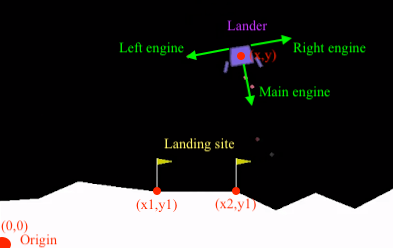

Notice that the action spaces for the agent is already defined. We assume the agent can control the lander by providing the amount of fire to be used to control the lander's engines. Hence, the action space is considered as continuous and composed of 2 **actions** (amount of fire for left/right engine, amount of fire for main engine). More details can be found in the description of the method `fire_engine(action)` of the class `LunarLander` in the file `lunar_landing_modules.py`. Rewards should be given based on the landing position and the quality of the descent, and on the usage of the fuel. Interactions should end if the lander crashes or when it lands successfully.

Let's install `gym`.

In [6]:
# Install packages related to gym and gym, necessary for our environment
!pip install box2d-py > /dev/null 2>&1
!pip install gym > /dev/null 2>&1
!pip install gym[Box_2D] > /dev/null 2>&1

And now let's define and instantiate the environment.

In [7]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding, EzPickle
import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

from lunar_landing_modules import World, LunarLander, LandingSite, ContactDetector, VIEWPORT_W, VIEWPORT_H, SCALE

class LunarLandingEnv(gym.Env, EzPickle):
    """
    Class to represent the environment the agents interacts with.
    In particular, this class represents the enviroment of a lunar landing task
    The environments defines:
        - the states (the information about the environment) the agent can observe
        - the actions the agent can take to change the environment
        - the reward given by the environment in response to the agent's action
        - the stopping conditions of the interaction

    Check the OpenAI's gym for further details
    """
    
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 50
    }

    def __init__(self):
        EzPickle.__init__(self)
        self.seed()
        self.viewer = None
        self.world = None

        self.np_random, seed = seeding.np_random(123)

        self.prev_reward = None
        
        # State space
        # states are represented as vectors of floats
        # STATE_SIZE reflects the number of features in each state vector
        STATE_SIZE = 8
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(STATE_SIZE,), dtype=np.float32)

        # Action space
        # actions are represented as vectors of two elements in the range [-1, +1]
        # the first one represents the intensity to be applied to the main engine of the lander
        # the second represents the intensity to be applied to the side engines of the lander
        # hence we have a countinous action space
        self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

    def reset(self):
        """
        Method that sets the env at the first state of the environment.
        This method has to be called at the beginning of each interaction process.

        Returns:
            a np.array representing the first state of the environment
        """
        # Defining a World object that manages the physics of the environment
        # and which will contain the landing site and the lander module
        self._destroy()
        self.world = World()
        self.world.world.contactListener_keepref = ContactDetector(self)
        self.world.world.contactListener = self.world.world.contactListener_keepref
        
        self.prev_cost = None

        # Definition of the landing site object
        self.landing_site = LandingSite(self.world, np_random=self.np_random)
        self.landing_site_x1, self.landing_site_x2, self.landing_site_y = self.landing_site.get_position()

        # Definition of the lander module object
        self.lander = LunarLander(self.world, np_random=self.np_random)

        ## TODO
        # Setup the first state of the environment
        x, y = self.lander.get_position()
        vx, vy = self.lander.get_velocity()
        angle = self.lander.get_angle()
        av = self.lander.get_angular_velocity()
        contact_left, contact_right = self.lander.legs_in_contact()

        state = [x, y, vx, vy, angle, av, contact_left, contact_right]
        
        return np.array(state, dtype=np.float32)

    def step(self, action):
        """
        Method that receives an action from the agent and applies it 
        to change the environment (it moves the env forward for a single time step)
        It returns the new state of the env, the reward given by the env, a flag that represents
        the end of the interaction, and additional infos

        Args:
            action: a numpy array of 2 elements in [-1, 1] representing the power to be applied to the engines

        Returns:
            - new state of the env, as defined by self.observation_space, computed after the application of the action,
            - the reward, as a float number, to feedback the agent
            - the boolean variable done that takes True value if the last state of the env is reached
            - additional infos about the environment
        """
        action = np.clip(action, -1, +1).astype(np.float32)

        ## TODO
        # Execute the action given the agent
        # This will change the environment
        # use the action given by the agent to activate the engine of the lander
        m_power, s_power = self.lander.fire_engine(action)

        # Compute the new state
        x, y = self.lander.get_position()
        vx, vy = self.lander.get_velocity()
        angle = self.lander.get_angle()
        av = self.lander.get_angular_velocity()
        contact_left, contact_right = self.lander.legs_in_contact()

        new_state = [x, y, vx, vy, angle, av, contact_left, contact_right]
        
        # Compute the reward to feedback the agent
        # i.e. evaluate the action of the action according to some 
        # performance measure you want to optimize
        # Hint: consider the distance between the lander and the landing site
        # Hint: you can also consider the fuel consumption
        landing_site_x = (self.landing_site_x1 + self.landing_site_x2) / 2
        distance_from_landing_site = np.sqrt((x - landing_site_x)  ** 2 + (y  - (self.landing_site_y + self.lander.leg_down_height)) ** 2)
        velocity = np.sqrt((vx ** 2) + (vy ** 2))
        
        amp_factor = 100
        reward = 0
        # Distance from the landing site, near to the landing site -> less penalization
        # Cost on the landing speed, slower -> cost lower
        cost = - amp_factor * distance_from_landing_site \
                - amp_factor * velocity \
                - amp_factor * abs(new_state[4]) + 10*float(new_state[6]) + 10*float(new_state[7])  # Put also a cost on the angle, lower angle -> better alignment with the ground 
                                                                                                # And ten points for legs contact, the idea is if you
                                                                                                # lose contact again after landing, you get negative reward
        
        # It makes sense to reward an action by calculating the gain it takes wrt to our goal
        # hence we consider the difference between the previous and current cost
        # if the gain is positive it means that the agent's action reduced the cost
        if self.prev_cost is not None:
            reward = cost - self.prev_cost
        self.prev_cost = cost

        # Consider fuel consumption
        # if we use more power we consume more fuel
        reward -= m_power * 0.50 
        reward -= s_power * 0.03

        # Compute the stopping criteria
        # check if the new_state could be the last of the interaction
        # e.g. if the lander is table on the moon's ground we assume that the landing
        # was successful and we can end the interaction as the goal is reached
        # on the other hand, the interaction must be stopped if the lander crashes or moves
        # away too far from the landing site
        done = False
        if self.lander.crashed() or x < 0 or x >= (VIEWPORT_W/SCALE + 1) or (y >= VIEWPORT_H/SCALE + 1):
            done = True
            # if we crash or move out the coordinate system
            # give an additionally bad reward
            reward = -100
        
        # If the lander is stable on the ground we assume it has landed correctly
        if self.lander.stable_on_terrain():
            done = True
            # if the lander lands safely
            # give an additional good reward
            reward = +100
            
        return np.array(new_state, dtype=np.float32), reward, done, {}


    def render(self, mode='human'):
        """
        Method to render the environment on screen
        """

        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
            self.viewer.set_bounds(0, VIEWPORT_W/SCALE, 0, VIEWPORT_H/SCALE)

        for obj in self.lander.particles:
            obj.ttl -= 0.15
            obj.color1 = (max(0.2, 0.2+obj.ttl), max(0.2, 0.5*obj.ttl), max(0.2, 0.5*obj.ttl))
            obj.color2 = (max(0.2, 0.2+obj.ttl), max(0.2, 0.5*obj.ttl), max(0.2, 0.5*obj.ttl))

        self.lander._clean_particles(False)

        for p in self.landing_site.sky_polys:
            self.viewer.draw_polygon(p, color=(0, 0, 0))

        for obj in self.lander.particles + [self.lander.lander] + self.lander.legs:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans*f.shape.pos)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color1).add_attr(t)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color2, filled=False, linewidth=2).add_attr(t)
                else:
                    path = [trans*v for v in f.shape.vertices]
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        landing_site_x1, landing_site_x2, landing_site_y = self.landing_site.get_position()
        for x in [landing_site_x1, landing_site_x2]:
            flagy1 = landing_site_y
            flagy2 = flagy1 + 50/SCALE
            self.viewer.draw_polyline([(x, flagy1), (x, flagy2)], color=(1, 1, 1))
            self.viewer.draw_polygon([(x, flagy2), (x, flagy2-10/SCALE), (x + 25/SCALE, flagy2 - 5/SCALE)],
                                     color=(0.8, 0.8, 0))

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')


    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.world: return
        self.world.world.contactListener = None
        self.lander._clean_particles(True)
        self.world.world.DestroyBody(self.landing_site.moon)
        self.landing_site.moon = None
        self.world.world.DestroyBody(self.lander.lander)
        self.lander.lander = None
        self.world.world.DestroyBody(self.lander.legs[0])
        self.world.world.DestroyBody(self.lander.legs[1])

# Create the environment
env = LunarLandingEnv()
env.seed(SEED)

# Print the observation and action spaces of the env
print('State space: {}'.format(env.observation_space))
print('Action space: {} - low: {} high: {}'.format(env.action_space, env.action_space.low[0], env.action_space.high[0]))

State space: Box(-inf, inf, (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32) - low: -1.0 high: 1.0


Fine! We are now ready the define the other blocks of our solution.

## Agent

Let's move now to the agent definition! The agent will be the controller of the lander, it will contain the policy, and it will be responsible for its learning and execution.

This time we will use the [`stable-baselines3`](https://github.com/DLR-RM/stable-baselines3) library which provides many PyTorch implementations of state-of-the-art RL algorithms.


There are also other resources such as [Spinning Up in Deep RL!](https://spinningup.openai.com/en/latest/) which is excellent to start working with RL.  Indeed,
it includes basic and advanced RL algorithms implementations with very detailed explanations. 
Algorithms and models are implemented by means of both PyTorch and TensorFlow frameworks.

However, let's install `stable-baseline3`.

In [8]:
!pip install stable-baselines3  > /dev/null 2>&1

As we will see in a minute, `stable-baseline3` allows us the train an RL agent with a single code statement. We need just to pass it the environment, some hyperparameters, and it will take care of agent initialization, learning, and so on.

Before that, let's see how `stable-baseline3` implements the agent.




In [9]:
from stable_baselines3.sac.policies import SACPolicy
from typing import Callable

# This function is needed just because the learning rate schedule is mandatory to 
# initialize the object representing the agent
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

# Instantiate the agent as an actor-critic agent composed of multi-layer perceptrons
agent = SACPolicy(env.observation_space, env.action_space, linear_schedule(0.001))

print(agent)

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=2, bias=True)
    (log_std): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bi

This is just a `torch.nn.Module` that contains an MLP for the stochastic policy `actor` (the actor), and two MLPs for the Q-value functions `critic` and `critic_target` (the critics). We can have a look to the detailed implementation [here](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/sac/policies.py).

## Interaction

Let's move to the implementation of the finite-horizon interaction procedure that must happen between agent and environment.
This is done by means of the ``run_episode`` function. Following the [general structure of `gym`'s environments](https://gym.openai.com/docs/#observations), a state will be obtained from the environment and it will be given in input to the agent which will produce its action. Then, the action will be passed to the environment which will return the reward. This procedure will run until the stopping conditions are met.

We will use this function for quantitive and qualitative evaluations, but a similar procedure is implemented by the `stable_baselines3` SAC algorithm during training. 


In [10]:
def run_episode(agent, env, render=False):
    """
    Given agent and env, runs an episode and returns the obtained rewards

    Args:
        agent: an object respecting the stable_baselines2 SACPolicy parameter
        env: a gym environment

    Returns:
        rewards: list of scalar rewards
    """
    # Empty lists to save rewards
    rewards = []        # for rewards

    if render:
        # Do not need this if you locally run this notebook as a script
        env = wrap_env(env)

    # Reset environment to the first state
    state = env.reset() 
    done = False            # signal from environment that episode is over

    # Run until the episode is finished
    while not done:

        # Render environment to screen
        if render:
            env.render()

        # Get the action from the agent for the current state
        # The SACPolicy class has a method .predict() which takes in input a state and returns the respective action
        action, _ = agent.predict(np.array(state, dtype=np.float32))
        
        # Perform action and receive reward and new state
        state, reward, done, _ = env.step(action)

        # Save reward
        rewards.append(reward)

    if render:
        # Do not need this if you locally run this notebook as a script
        env.close()
        show_video()

    return rewards


Let's use `run_episode` to see how the agent performs without training.

In [11]:
from stable_baselines3 import SAC

# Define and initialized the agent with some hyperparameters
agent = SAC("MlpPolicy", env, learning_rate=0.001, batch_size=100, tau=0.995, seed=SEED, verbose=1)

rewards = run_episode(agent, env, render=True)

print('R(tau) = {}'.format(sum(rewards)))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


R(tau) = -208.45036023396162


## Training

Let's arrive to the actual learning phase!

As we said, we will use the Soft Actor-Critic algorithm, which is a state-of-the-art off-policy RL algorithm particularly designed for robotics and control problems. 

Here are some features:


*   Stochastic Policy optimization in an Off-Policy way
    - It bridges the sample efficiency of off-policy methods with the stability of policy optimization

*   Entropy Regularization
    - Maximization of policy entropy for better exploration


*   Double Critic trick
    - To reduce bias and make learning faster



For the details of the algorithm, Spinning Up in Deep RL! gives a [very good tutorial](https://spinningup.openai.com/en/latest/algorithms/sac.html). Here we can have a look to the pseudocode.

![alt text](https://imgur.com/oNsh1a8.png)


With the `stable_baselines3` implementation is just matter of a single statement. If you are interested how it is defined inside, check [here](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/sac/sac.py).

Now let's train!

Hint: use Colab's GPU to make the learning faster.

In [12]:
# Train the agent
agent.learn(total_timesteps=100000, log_interval=4)

# Save the learned agent to file
agent.save("lander_controller_agent")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 63.2     |
|    ep_rew_mean     | -835     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 131      |
|    time_elapsed    | 1        |
|    total timesteps | 253      |
| train/             |          |
|    actor_loss      | 616      |
|    critic_loss     | 1.15e+03 |
|    ent_coef        | 0.888    |
|    ent_coef_loss   | -0.384   |
|    learning_rate   | 0.001    |
|    n_updates       | 152      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 75.8     |
|    ep_rew_mean     | -730     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 103      |
|    time_elapsed    | 5        |
|    total timesteps | 606      |
| train/             |          |
|    actor_loss      | 229      |
|    critic_loss     | 4.36e+03 |
|    ent_coef 

## Evaluating

Let's see how our trained agent performs!

In [13]:
# Load the agent from the checkpoint
agent = SAC.load("lander_controller_agent") 

# Qualitatively evaluate the performance of the agent on 5 episodes
for e in range(5):
    rewards = run_episode(agent, env, render=True)

    R = sum(rewards)

    print('Test episode {} - R(tau) = {}'.format(e, R))

Test episode 0 - R(tau) = 1095.0389031394034


Test episode 1 - R(tau) = 1091.868272246812


Test episode 2 - R(tau) = 1248.4807160957296


Test episode 3 - R(tau) = 1101.8921032228368


Test episode 4 - R(tau) = 1188.5377161456493


Not bad!

Next step

In [14]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/1sJlFzUQVmY?start=74" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


You can use [this env](https://github.com/EmbersArc/gym-rocketlander)!